# ACT EPA Vector Extraction

This notebook demonstrates extracting Evaluation, Potency, and Activity (EPA) direction vectors from Llama-3.1-8B-Instruct using Representation Engineering.

## Setup

In [1]:
import sys
sys.path.append('../..')

import torch
import numpy as np
import pickle
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from repe import repe_pipeline_registry

# Register RepE pipelines
repe_pipeline_registry()

from utils import (
    create_all_epa_datasets,
    EPA_DIMENSIONS,
    plot_tsne_epa,
)

c:\Users\Kyra\mambaforge-pypy3\envs\repeng\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model

In [2]:
model_name = "meta-llama/Llama-3.1-8B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

print(f"Model loaded: {model_name}")
print(f"Layers: {model.config.num_hidden_layers}")

Loading checkpoint shards: 100%|██████████| 4/4 [00:12<00:00,  3.19s/it]


Model loaded: meta-llama/Llama-3.1-8B-Instruct
Layers: 32


## Create Datasets

Create contrastive datasets for each EPA dimension using the ACT data files.

In [3]:
data_dir = "../../data/act"
n_train = 256  # Number of contrastive pairs per dimension

datasets = create_all_epa_datasets(data_dir, n_train=n_train, seed=42)

for dim, data in datasets.items():
    print(f"{dim}: {len(data['train']['data'])} prompts ({len(data['train']['labels'])} pairs)")

evaluation: 512 prompts (256 pairs)
potency: 512 prompts (256 pairs)
activity: 512 prompts (256 pairs)


In [4]:
# Example prompts
print("=== Example Evaluation Prompt (Positive) ===")
print(datasets['evaluation']['train']['data'][0])
print("\n=== Example Evaluation Prompt (Negative) ===")
print(datasets['evaluation']['train']['data'][1])

=== Example Evaluation Prompt (Positive) ===
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a human participating in a verbal conversation. Your goal is to generate a response that is a pure representation of a specific social dimension from Affect Control Theory.

The EPA Framework:
- Evaluation (Good vs. Bad): Refers to morality, altruism, and social desirability.
- Potency (Potent vs. Impotent): Refers to power, authority, dominance, and strength.
- Activity (Active vs. Inactive): Refers to energy level, speed, volatility, and liveliness.

Your Task: Respond to the user while being perceived as extremely good.

Constraints:
- Neutrality: On the other two dimensions, you must remain strictly neutral. Do not lean toward being potent or impotent. Do not lean toward being active or inactive.
- Subtlety: Avoid using the target word itself. Instead, embody the essence of the dimension through your tone, word choice, and social posture.
- Naturalism: Maintain the flow

## Extract EPA Directions

Use PCA on the difference between contrastive hidden states to extract EPA directions.

In [5]:
# Create RepReading pipeline
rep_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

# Define layers to extract from (negative indices = from end)
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
print(f"Extracting from {len(hidden_layers)} layers: {hidden_layers[:5]}...{hidden_layers[-5:]}")

Device set to use cuda:0


Extracting from 31 layers: [-1, -2, -3, -4, -5]...[-27, -28, -29, -30, -31]


In [6]:
# Extract directions for each EPA dimension
rep_readers = {}

for dimension in ["evaluation", "potency", "activity"]:
    print(f"\n{'='*50}")
    print(f"Extracting {dimension.upper()} direction...")
    print(f"{'='*50}")
    
    data = datasets[dimension]
    
    rep_reader = rep_pipeline.get_directions(
        data['train']['data'],
        rep_token=-1,  # Last token
        hidden_layers=hidden_layers,
        n_difference=1,
        train_labels=data['train']['labels'],
        direction_method='pca',
        direction_finder_kwargs={'n_components': 1},
        batch_size=8,
        padding=True,
        truncation=True,
        max_length=512,
    )
    
    rep_readers[dimension] = rep_reader
    print(f"Direction shape: {rep_reader.directions[-1].shape}")
    print(f"Direction signs: {list(rep_reader.direction_signs.items())[:3]}...")

print("\n✓ All EPA directions extracted!")


Extracting EVALUATION direction...
Direction shape: (1, 4096)
Direction signs: [(-1, array([-1.])), (-2, array([1.])), (-3, array([1.]))]...

Extracting POTENCY direction...
Direction shape: (1, 4096)
Direction signs: [(-1, array([1.])), (-2, array([1.])), (-3, array([1.]))]...

Extracting ACTIVITY direction...
Direction shape: (1, 4096)
Direction signs: [(-1, array([-1.])), (-2, array([1.])), (-3, array([1.]))]...

✓ All EPA directions extracted!


## Save Directions

In [7]:
# Save for later use
save_path = "epa_directions.pkl"

with open(save_path, 'wb') as f:
    pickle.dump({
        'rep_readers': rep_readers,
        'hidden_layers': hidden_layers,
        'model_name': model_name,
    }, f)

print(f"Saved EPA directions to {save_path}")

Saved EPA directions to epa_directions.pkl


## Visualize with t-SNE

Visualize EPA representations in early and late layers using t-SNE (Figure 14 style).

In [8]:
import matplotlib.pyplot as plt

# Get hidden states for visualization
dimension = "evaluation"  # Change to visualize other dimensions
data = datasets[dimension]

# Get raw hidden states
hidden_states = rep_pipeline(
    data['train']['data'][:100],  # Limit for speed
    hidden_layers=hidden_layers,
    rep_reader=None,  # Get raw hidden states
    batch_size=8,
    padding=True,
    truncation=True,
)

print(f"Got hidden states for {len(hidden_states)} prompts")

Got hidden states for 100 prompts


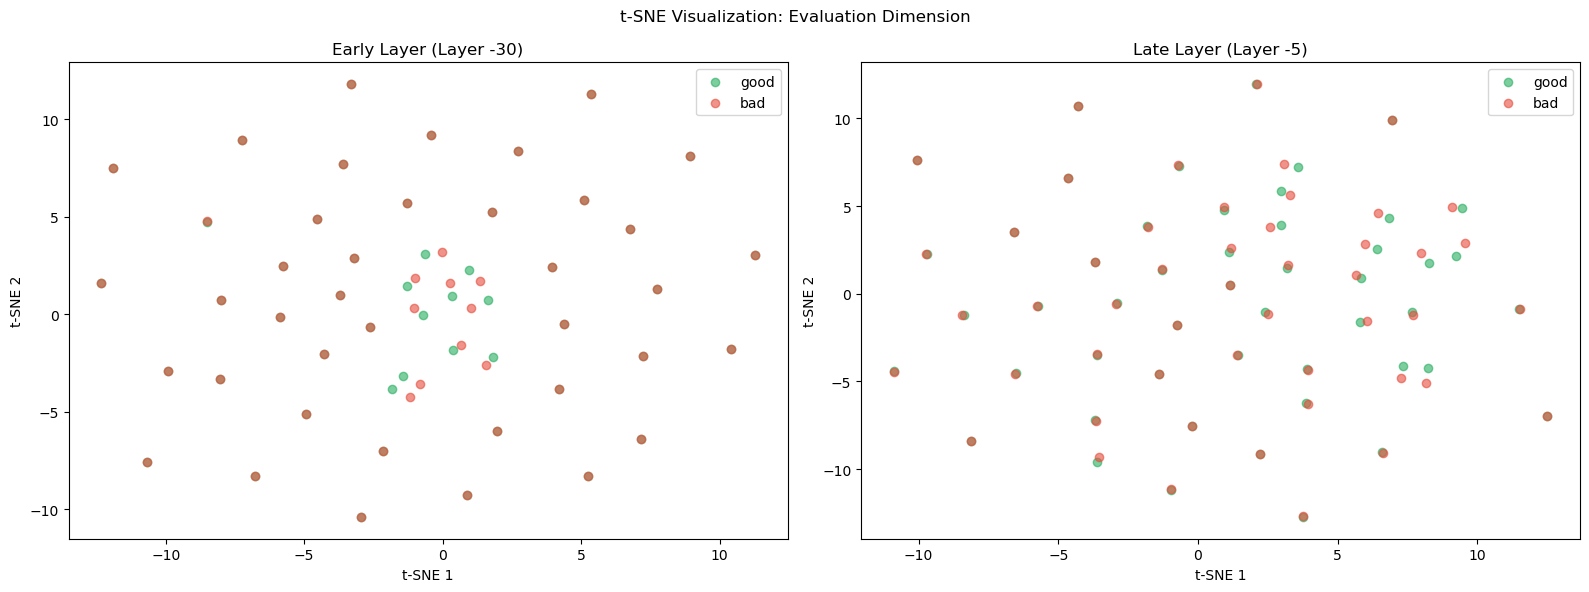

In [9]:
# Create t-SNE visualizations for early and late layers
early_layer = -30  # Early layer
late_layer = -5    # Late layer

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, layer, title in [(axes[0], early_layer, "Early Layer"), 
                          (axes[1], late_layer, "Late Layer")]:
    # Separate positive and negative
    pos_states = []
    neg_states = []
    
    for i, h in enumerate(hidden_states):
        if layer in h:
            if i % 2 == 0:  # Even indices are from first in pair
                label_idx = i // 2
                if label_idx < len(data['train']['labels']):
                    is_pos = data['train']['labels'][label_idx][0]
                    if is_pos:
                        pos_states.append(h[layer])
                    else:
                        neg_states.append(h[layer])
            else:
                label_idx = i // 2
                if label_idx < len(data['train']['labels']):
                    is_pos = data['train']['labels'][label_idx][1]
                    if is_pos:
                        pos_states.append(h[layer])
                    else:
                        neg_states.append(h[layer])
    
    if pos_states and neg_states:
        from sklearn.manifold import TSNE
        
        pos_arr = np.vstack(pos_states[:50])
        neg_arr = np.vstack(neg_states[:50])
        all_states = np.vstack([pos_arr, neg_arr])
        
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        embedded = tsne.fit_transform(all_states)
        
        ax.scatter(embedded[:len(pos_arr), 0], embedded[:len(pos_arr), 1], 
                  c='#27ae60', label=EPA_DIMENSIONS[dimension]['positive'], alpha=0.6)
        ax.scatter(embedded[len(pos_arr):, 0], embedded[len(pos_arr):, 1], 
                  c='#e74c3c', label=EPA_DIMENSIONS[dimension]['negative'], alpha=0.6)
        ax.set_title(f"{title} (Layer {layer})")
        ax.legend()
        ax.set_xlabel("t-SNE 1")
        ax.set_ylabel("t-SNE 2")

plt.suptitle(f"t-SNE Visualization: {dimension.capitalize()} Dimension")
plt.tight_layout()
plt.savefig(f"tsne_{dimension}.png", dpi=150, bbox_inches='tight')
plt.show()

## Validate Directions

Test that the extracted directions correctly distinguish positive from negative examples.

In [10]:
# Test direction accuracy
for dimension in ["evaluation", "potency", "activity"]:
    data = datasets[dimension]
    reader = rep_readers[dimension]
    
    # Get scores for test subset
    test_data = data['train']['data'][:50]  # First 50 prompts (25 pairs)
    test_labels = data['train']['labels'][:25]
    
    scores = rep_pipeline(
        test_data,
        hidden_layers=hidden_layers,
        rep_reader=reader,
        batch_size=8,
        padding=True,
        truncation=True,
    )
    
    # Calculate accuracy per layer
    best_acc = 0
    best_layer = None
    
    for layer in hidden_layers:
        correct = 0
        total = 0
        
        for i in range(0, len(scores), 2):
            pair_idx = i // 2
            if pair_idx >= len(test_labels):
                break
                
            score1 = scores[i][layer]
            score2 = scores[i+1][layer]
            
            # Positive should have higher score
            if test_labels[pair_idx][0]:  # First is positive
                correct += 1 if score1 > score2 else 0
            else:  # Second is positive
                correct += 1 if score2 > score1 else 0
            total += 1
        
        acc = correct / total if total > 0 else 0
        if acc > best_acc:
            best_acc = acc
            best_layer = layer
    
    print(f"{dimension.capitalize()}: Best accuracy = {best_acc:.1%} at layer {best_layer}")

Evaluation: Best accuracy = 100.0% at layer -2
Potency: Best accuracy = 100.0% at layer -1
Activity: Best accuracy = 100.0% at layer -2


## Next Steps

Now that EPA directions are extracted and saved:

1. **Reading**: Use `act_reading_control.ipynb` to read EPA values from user input
2. **Control**: Apply EPA vectors to steer generation
3. **Visualize**: Use `act_visualizations.ipynb` for detailed visualizations